In [1]:
from pathlib import Path
from pku_autonomous_driving import io, util, improc, dataset, resnet, centernet, training

In [2]:
import importlib
importlib.reload(io)
importlib.reload(util)
importlib.reload(improc)
importlib.reload(dataset)
importlib.reload(resnet)
importlib.reload(centernet)
importlib.reload(training)

<module 'pku_autonomous_driving.training' from '/Users/argon/workspace/managed/pku-autonomous-driving/pku_autonomous_driving/training.py'>

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
train = io.load_train_data(max_num=32)
test = io.load_test_data()

In [5]:
from pku_autonomous_driving.dataset import create_train_dataset
train_dataset, dev_dataset = create_train_dataset(train, test_size=0.08)

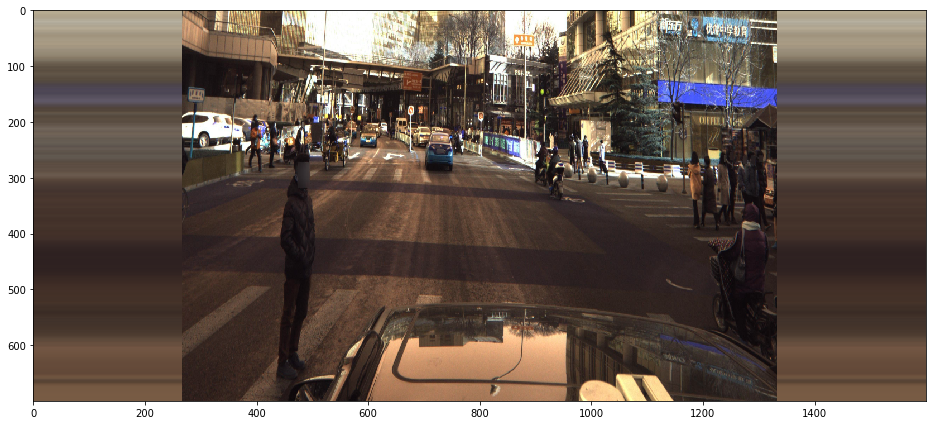

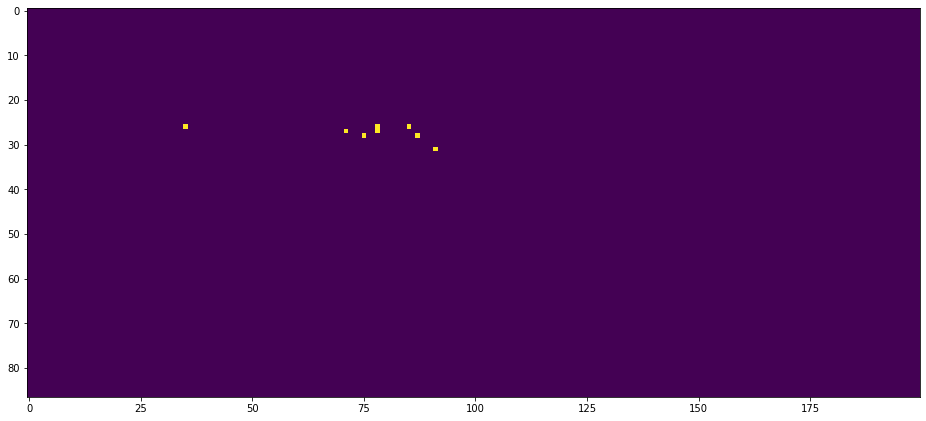

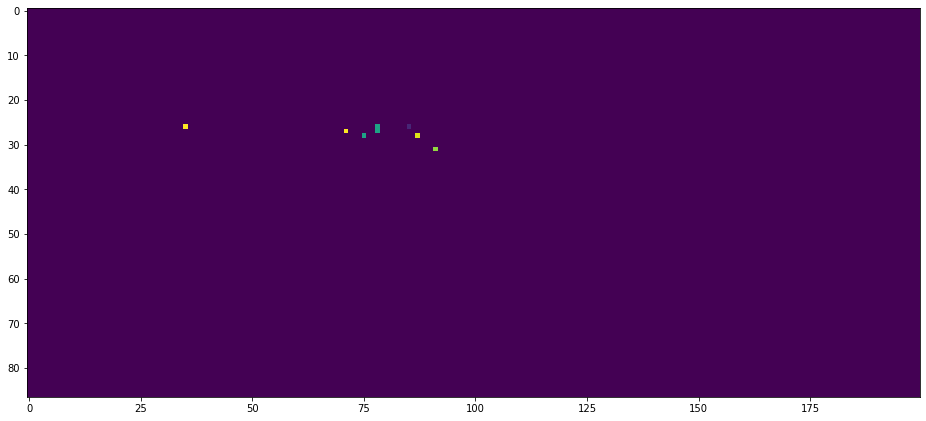

In [6]:
import matplotlib.pyplot as plt
import numpy as np

img, mask, regr = train_dataset[0]

plt.figure(figsize=(16,16))
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(mask)
plt.show()

plt.figure(figsize=(16,16))
plt.imshow(regr[-2])
plt.show()

In [7]:
from torch.utils.data import DataLoader
BATCH_SIZE = 1

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
dev_loader = DataLoader(dataset=dev_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [8]:
base_model = resnet.resnext50_32x4d(pretrained=False)
model = centernet.CentResnet(base_model, 8).to(device)

In [9]:
%%time
from torch import optim
from torch.optim import lr_scheduler
import pandas as pd

n_epochs = 8

optimizer = optim.AdamW(model.parameters(), lr=0.001)
#optimizer =  RAdam(model.parameters(), lr = 0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=max(n_epochs, 10) * len(train_loader) // 3, gamma=0.1)

history = pd.DataFrame()
for epoch in range(n_epochs):
    training.clean_up()
    training.train(model, optimizer, exp_lr_scheduler, train_loader, epoch, device, history)
    training.evaluate(model, dev_loader, epoch, device, history)

dafdsfasdf


KeyboardInterrupt: 

In [52]:
torch.save(model.state_dict(), './resnext50.pth')

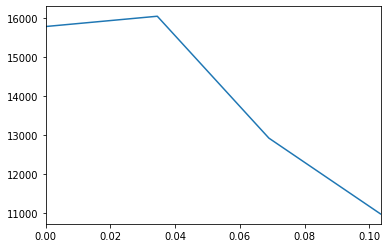

In [55]:
history['train_loss'].iloc[:].plot();

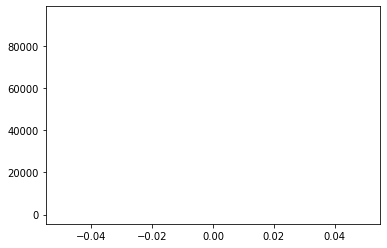

In [56]:
series1 = history.dropna()['mask_loss']
plt.plot(series1.index, series1 ,label = 'mask loss');
series2 = history.dropna()['regr_loss']
plt.plot(series2.index, 30*series2,label = 'regr loss');
series3 = history.dropna()['dev_loss']
plt.plot(series3.index, series3,label = 'dev loss');
plt.show()

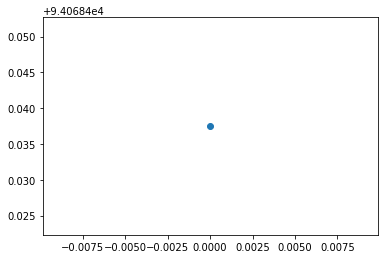

In [57]:
series = history.dropna()['dev_loss']
plt.scatter(series.index, series);

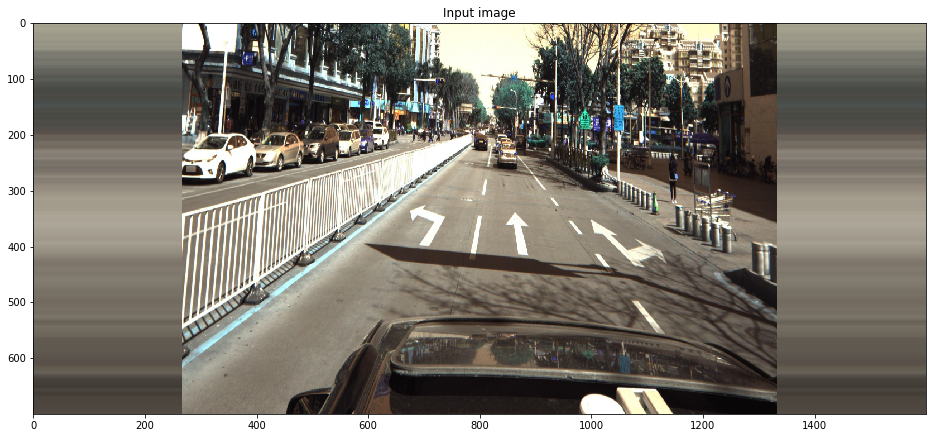

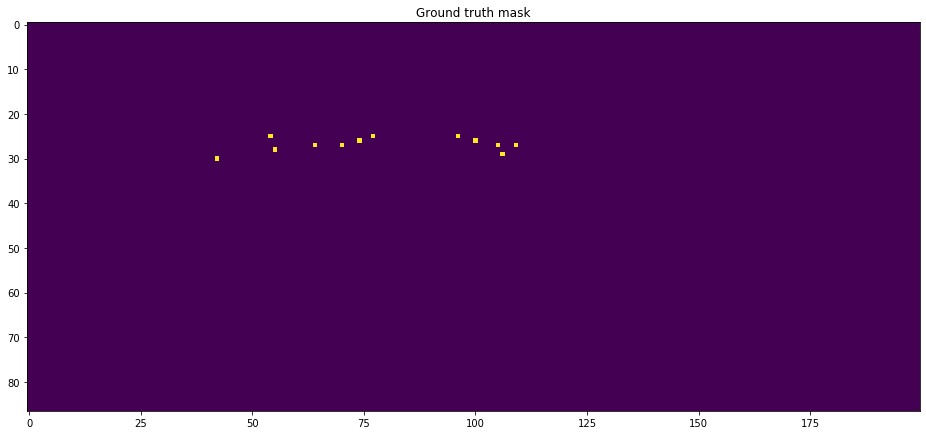

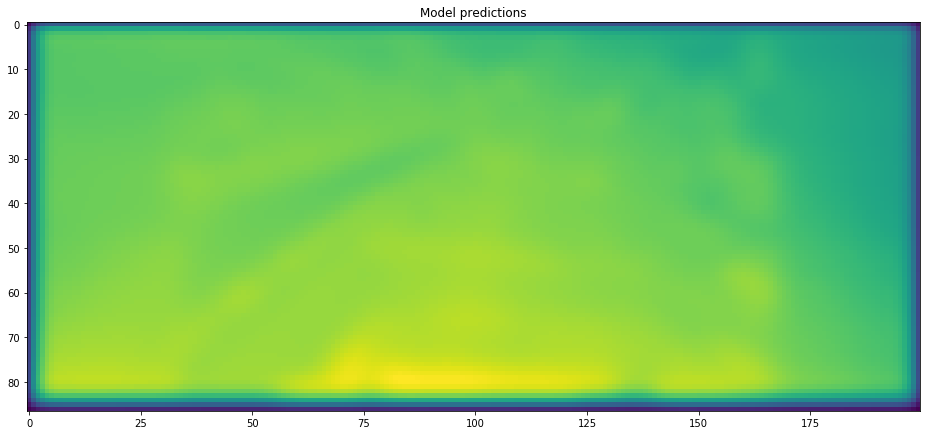

[[0.3132684  1.0146458  1.5498533  ... 1.2448204  0.89958453 0.4703297 ]
 [0.9811651  2.2406068  3.167446   ... 2.481099   1.8211015  0.94484866]
 [1.2539108  2.7509773  3.8256779  ... 3.0569444  2.3071032  1.2438083 ]
 ...
 [0.9459502  2.0951478  2.9155455  ... 2.4825644  1.8696523  0.9847065 ]
 [0.47566757 1.1954591  1.7514101  ... 1.451947   1.0499024  0.49190083]
 [0.06444323 0.3316868  0.5769487  ... 0.474212   0.28449103 0.07683808]]


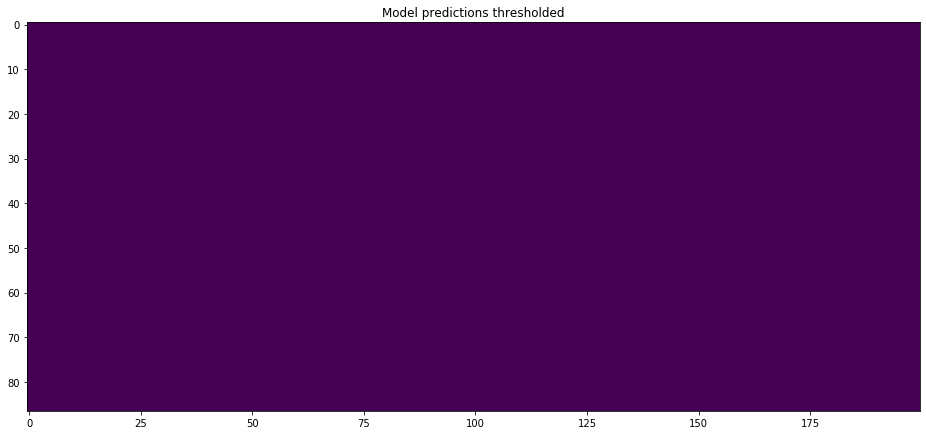

In [58]:
img, mask, regr = dev_dataset[0]

plt.figure(figsize=(16,16))
plt.title('Input image')
plt.imshow(np.rollaxis(img, 0, 3))
plt.show()

plt.figure(figsize=(16,16))
plt.title('Ground truth mask')
plt.imshow(mask)
plt.show()

output = model(torch.tensor(img[None]).to(device))
logits = output[0,0].data.cpu().numpy()

plt.figure(figsize=(16,16))
plt.title('Model predictions')
plt.imshow(logits)
plt.show()

print(logits)
plt.figure(figsize=(16,16))
plt.title('Model predictions thresholded')
plt.imshow(logits > 0)
plt.show()

In [59]:
## Simple test of probabilities
act = torch.nn.Sigmoid()
logtens = torch.from_numpy(logits)
probs = act(logtens)
probs = probs[probs>0]
print(probs)

tensor([0.5777, 0.7339, 0.8249,  ..., 0.6164, 0.5706, 0.5192])


In [60]:
from pku_autonomous_driving import util, io
importlib.reload(util)
importlib.reload(io)

from pku_autonomous_driving.util import extract_coords
from pku_autonomous_driving.io import load_image
import numpy as np
import gc
gc.collect()

for idx in range(4):
    img, mask, regr = dev_dataset[idx]
    
    output = model(torch.tensor(img[None]).to(device)).data.cpu().numpy()
    coords_pred = extract_coords(output[0])
    coords_true = extract_coords(np.concatenate([mask[None], regr], 0))
    
    img = load_image(df_dev['ImageId'].iloc[idx])
    
    fig, axes = plt.subplots(1, 2, figsize=(30,30))
    axes[0].set_title('Ground truth')
    axes[0].imshow(visualize(img, coords_true))
    axes[1].set_title('Prediction')
    axes[1].imshow(visualize(img, coords_pred))
    plt.show()

NameError: name 'gc' is not defined